In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

if os.getcwd()[-7:] == 'AAM_Sim':
    print(os.getcwd())
else:
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    path_parent = os.path.dirname(os.getcwd())
    os.chdir(path_parent)
    print(os.getcwd())
    
from Engine.GlobalClock import GlobalClock, Agent
from Engine.State import State
from Engine.Aircraft import AircraftType
from Engine.FlightPlan import FlightPlan
from Engine.MultiRotorController import MultiRotorController
from Engine.Wind import WindField
from Engine.Sensors import NavUpdate, GPSPosNavUpdate
from Engine.DragModel import DragModel
from Engine.TrackingSystem import *
from Engine.ConflictDetector import ConflictDetector

from CrossPlatformDev import my_print, join_str

import time

C:\Users\quekz\PycharmProjects\AAM_Sim


In [2]:
def FP_gen(HDG, speed, time, num_wpts, ini_pos):
    """Function that generates a flight plan according to encounter design. 
    A/C have fixed heading and will fly toward WPTs. 
    HDG --> desired A/C HDG (counter-clockwise from x-axis in RADIANS)
    speed --> desired A/C cruise spd
    time --> approximate duration for each flight leg (between 2 consecutive wpts)
    num_wpts --> number of wpts along the flight path
    ini_pos --> initial position of the A/C
    """
    wpt_list = []
    wpt_times = []
    spds = []
    mode_list = []
    duration_list = []
    for i in range(num_wpts):
        wpt_list.append(ini_pos + i*speed*time*np.array([np.cos(HDG), np.sin(HDG), 0]))
        wpt_times.append(i*time*1.1) # Give a 10% margin to each leg duration
        if i > 0:
            spds.append(speed)
            mode_list.append('Direct_P2P')
            duration_list.append(time*1.1) # Give a 10% margin to each leg duration
    wpt_start_list = wpt_list[0:num_wpts-1]
    wpt_end_list = wpt_list[1:]
    wpt_start_time = wpt_times[0:num_wpts-1]
    wpt_end_time = wpt_times[1:]
    return (FlightPlan(spds, mode_list,
                       wpt_start_list, wpt_start_time,
                       wpt_end_list, wpt_end_time, duration_list), wpt_list)


def calc_diameter(mass):
    """Data for this function obtained from log-log plot of popular DJI quadrotors"""
    if isinstance(mass, type(np.array([]))):
        diameter = (np.random.uniform(0.8, 1.2, size=len(mass)) * np.exp((0.3878 * np.log(mass) + 2.1387))).round(1)
    else:
        diameter = round(np.random.uniform(0.8, 1.2) * np.exp((0.3878 * np.log(mass) + 2.1387)), 1)
    return diameter


def estimate_max_linear_dim(prop_diam):
    """Estimates max linear dimension (m) based on prop diameter (inches). Based on commercially available DJI
    drone dimensions. """
    return 0.018*prop_diam + 0.2884

In [3]:
# File to be used for generating initial params

# Number of runs
num_runs = 10

# Global Params

GlobalPhysicsUpdateRate = 240 
GlobalSimStopTime = 200 
Cruise_Leg_Time = 15 
Num_Legs = 5 

WindUpdateRate = 1 
Wind_auto_x = 0.9 
Wind_auto_y = 0.9 
Wind_auto_z = 0
Wind_std_x = 3 
Wind_std_y = 3
Wind_std_z = 0 
Wind_mean_x = 0 
Wind_mean_y = 0 
Wind_mean_z = 0

# Some shared AC Params for this simulation

# AC GPS Error Models
GPS_Pos_Error_Hor_Auto = 0.994
GPS_Pos_Error_Vert_Auto = 0.994
GPS_Pos_Error_Hor_Std = 3.5 # (radial)
GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std)/np.sqrt(0.5*(4-np.pi)) # Check formula! 
# GPS_Pos_Error_Hor_Std = (GPS_Pos_Error_Hor_Std/2)/np.sqrt(0.5*(4-np.pi)) # Pls chk formula before running!
GPS_Pos_Error_Vert_Std = 3.5

# AC Cruise Spds
spd = 10

# AC1 Params
AC1_Mass = 1.2
AC1_Prop_Diameter = calc_diameter(AC1_Mass)
AC1_HDG = 0 
AC1_HDG = AC1_HDG * np.pi/180
AC1_Cruise_Speed = spd
radii = np.random.uniform(150,250)
AC1_Ini_Pos_x = -radii * np.cos(AC1_HDG)
AC1_Ini_Pos_y = -radii * np.sin(AC1_HDG)
AC1_Ini_Pos_z =  0
AC1_Ini_Pos = np.array([AC1_Ini_Pos_x, AC1_Ini_Pos_y, AC1_Ini_Pos_z])

AC1_Ini_Vel_x = 0
AC1_Ini_Vel_y = 0
AC1_Ini_Vel_z = 0
AC1_Ini_Vel = np.array([AC1_Ini_Vel_x, AC1_Ini_Vel_y, AC1_Ini_Vel_z])

AC1_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC1_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC1_GPS_horizontal_auto = AC1_GPS_horizontal_auto 

AC1_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC1_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC1_GPS_vert_auto = AC1_GPS_vert_auto 

AC1_Ini_Pos_Err_x = np.random.normal(0, AC1_GPS_horizontal_std)
AC1_Ini_Pos_Err_y = np.random.normal(0, AC1_GPS_horizontal_std)
AC1_Ini_Pos_Err_z =  np.random.normal(0, AC1_GPS_vert_std)
AC1_Ini_Pos_Err = np.array([AC1_Ini_Pos_Err_x, AC1_Ini_Pos_Err_y, AC1_Ini_Pos_Err_z])

AC1_GPS_horizontal_std = AC1_GPS_horizontal_std
AC1_GPS_vert_std = AC1_GPS_vert_std 

AC1_Ini_Vel_Err_x = 0
AC1_Ini_Vel_Err_y = 0
AC1_Ini_Vel_Err_z = 0
AC1_Ini_Vel_Err = np.array([AC1_Ini_Vel_Err_x, AC1_Ini_Vel_Err_y, AC1_Ini_Vel_Err_z])

AC1_Ini_RPY_r = 0
AC1_Ini_RPY_p = 0
AC1_Ini_RPY_y = 0
AC1_Ini_RPY = np.array([AC1_Ini_RPY_r, AC1_Ini_RPY_p, AC1_Ini_RPY_y])

AC1_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC1_Controller_UpdateRate = 120 
AC1_Start_Time = 0

AC1_PosUpdateRate = 10
AC1_VelUpdateRate = 10
AC1_AccelUpdateRate = 120 
AC1_AirSpdSensorUpdateRate = 120

# Initialize AC1 Tracking System

AC1_TrackingUnit_UpdateRate = 2 
AC1_TrackingUnit_Pos_Quant = 0 
AC1_TrackingUnit_Vel_Quant = 0
AC1_TrackingUnit_Avail = 0.5 
AC1_Latency = 0.5 


# AC2 Params
AC2_Mass = 1.2 
AC2_Prop_Diameter = calc_diameter(AC2_Mass)
AC2_HDG = 90 
AC2_HDG = AC2_HDG * np.pi/180
AC2_Cruise_Speed = spd
radii = np.random.uniform(150,250)
AC2_Ini_Pos_x = -radii * np.cos(AC2_HDG)
AC2_Ini_Pos_y = -radii * np.sin(AC2_HDG)
AC2_Ini_Pos_z =  0
AC2_Ini_Pos = np.array([AC2_Ini_Pos_x, AC2_Ini_Pos_y, AC2_Ini_Pos_z])

AC2_Ini_Vel_x = 0
AC2_Ini_Vel_y = 0
AC2_Ini_Vel_z = 0
AC2_Ini_Vel = np.array([AC2_Ini_Vel_x, AC2_Ini_Vel_y, AC2_Ini_Vel_z])

AC2_GPS_horizontal_std = GPS_Pos_Error_Hor_Std
AC2_GPS_horizontal_auto = GPS_Pos_Error_Hor_Auto
AC2_GPS_horizontal_auto = AC2_GPS_horizontal_auto 

AC2_GPS_vert_std = GPS_Pos_Error_Vert_Std
AC2_GPS_vert_auto = GPS_Pos_Error_Vert_Auto
AC2_GPS_vert_auto = AC2_GPS_vert_auto 

AC2_Ini_Pos_Err_x = np.random.normal(0, AC2_GPS_horizontal_std)
AC2_Ini_Pos_Err_y = np.random.normal(0, AC2_GPS_horizontal_std)
AC2_Ini_Pos_Err_z =  np.random.normal(0, AC2_GPS_vert_std)
AC2_Ini_Pos_Err = np.array([AC2_Ini_Pos_Err_x, AC2_Ini_Pos_Err_y, AC2_Ini_Pos_Err_z])

AC2_GPS_horizontal_std = AC2_GPS_horizontal_std 
AC2_GPS_vert_std = AC2_GPS_vert_std 

AC2_Ini_Vel_Err_x = 0
AC2_Ini_Vel_Err_y = 0
AC2_Ini_Vel_Err_z = 0
AC2_Ini_Vel_Err = np.array([AC2_Ini_Vel_Err_x, AC2_Ini_Vel_Err_y, AC2_Ini_Vel_Err_z])

AC2_Ini_RPY_r = 0
AC2_Ini_RPY_p = 0
AC2_Ini_RPY_y = 0
AC2_Ini_RPY = np.array([AC2_Ini_RPY_r, AC2_Ini_RPY_p, AC2_Ini_RPY_y])

AC2_PhysicsUpdateRate = GlobalPhysicsUpdateRate # Already converted to array!
AC2_Controller_UpdateRate = 120
AC2_Start_Time = 0 

AC2_PosUpdateRate = 10 
AC2_VelUpdateRate = 10 
AC2_AccelUpdateRate = 120 
AC2_AirSpdSensorUpdateRate = 120 

# Initialize AC2 Tracking System

AC2_TrackingUnit_UpdateRate = 2 
AC2_TrackingUnit_Pos_Quant = 0 
AC2_TrackingUnit_Vel_Quant = 0 
AC2_TrackingUnit_Avail = 0.5 
AC2_Latency = 0.5 

In [4]:
# Init All Agents/Classes

# Global Agents Init (Clock, Wind, etc.)

Wind = WindField(WindUpdateRate, 0, 
                 auto_x=Wind_auto_x, auto_y=Wind_auto_y, auto_z=Wind_auto_z,
                 std_x=Wind_std_x, std_y=Wind_std_y, std_z=Wind_std_z,
                 mean_x=Wind_mean_x, mean_y=Wind_mean_y, mean_z=Wind_mean_z)

clock = GlobalClock(update_rate=GlobalPhysicsUpdateRate, stop=GlobalSimStopTime, start=0)

# AC1 Flight Agents Init

AC1_AircraftType = AircraftType(mass=AC1_Mass, prop_diameter=AC1_Prop_Diameter, max_cruise_spd=20)
AC1_DragModel = DragModel(AC1_AircraftType, disabled=False)

AC1_State = State(AC1_PhysicsUpdateRate, AC1_Start_Time, 
                  AC1_Ini_Pos, AC1_Ini_Vel, 
                  AC1_Ini_Pos_Err, AC1_Ini_Vel_Err, 
                  Wind.get_windspd(AC1_Start_Time, AC1_Ini_Pos), AC1_AircraftType, 
                  rpy=AC1_Ini_RPY)

AC1_FlightPlan, AC1_WPTs = FP_gen(AC1_HDG, AC1_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC1_Ini_Pos)

AC1_Controller = MultiRotorController(AC1_Controller_UpdateRate, AC1_Start_Time, AC1_FlightPlan, AC1_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC1_Pos_Nav_Agent = GPSPosNavUpdate(AC1_PosUpdateRate, AC1_Start_Time, 
                                    AC1_GPS_horizontal_auto, AC1_GPS_horizontal_auto, AC1_GPS_vert_auto,
                                    AC1_GPS_horizontal_std, AC1_GPS_horizontal_std, AC1_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC1_Vel_Nav_Agent = NavUpdate(AC1_VelUpdateRate, AC1_Start_Time)
AC1_Accel_Nav_Agent = NavUpdate(AC1_AccelUpdateRate, AC1_Start_Time)
AC1_AirSpeedSensor = NavUpdate(AC1_AirSpdSensorUpdateRate, AC1_Start_Time)

# AC1 Tracking System Init

AC1_TrackingUnit = TrackingUnit('AC1', AC1_TrackingUnit_UpdateRate, AC1_Start_Time, 
                                AC1_Latency, latency_distribution=None, 
                                availability=AC1_TrackingUnit_Avail,
                                pos_quant=AC1_TrackingUnit_Pos_Quant, vel_quant=AC1_TrackingUnit_Vel_Quant,
                                phase_delay=None)

# AC2 Flight Agents Init

AC2_AircraftType = AircraftType(mass=AC2_Mass, prop_diameter=AC2_Prop_Diameter, max_cruise_spd=20)
AC2_DragModel = DragModel(AC2_AircraftType, disabled=False)

AC2_State = State(AC2_PhysicsUpdateRate, AC2_Start_Time, 
                  AC2_Ini_Pos, AC2_Ini_Vel, 
                  AC2_Ini_Pos_Err, AC2_Ini_Vel_Err, 
                  Wind.get_windspd(AC2_Start_Time, AC2_Ini_Pos), AC2_AircraftType, 
                  rpy=AC2_Ini_RPY)

AC2_FlightPlan, AC2_WPTs = FP_gen(AC2_HDG, AC2_Cruise_Speed, Cruise_Leg_Time, Num_Legs+1, AC2_Ini_Pos)

AC2_Controller = MultiRotorController(AC2_Controller_UpdateRate, AC2_Start_Time, AC2_FlightPlan, AC2_AircraftType,
                                      wpt_tol_hor=0, wpt_tol_vert=0, wpt_tol=10)

AC2_Pos_Nav_Agent = GPSPosNavUpdate(AC2_PosUpdateRate, AC2_Start_Time, 
                                    AC2_GPS_horizontal_auto, AC2_GPS_horizontal_auto, AC2_GPS_vert_auto,
                                    AC2_GPS_horizontal_std, AC2_GPS_horizontal_std, AC2_GPS_vert_std,
                                    x_mean=0, y_mean=0, z_mean=0)
                                    # phase_delay=10 <-- manually set GPS phase delay during start-up (will rand if None)
AC2_Vel_Nav_Agent = NavUpdate(AC2_VelUpdateRate, AC2_Start_Time)
AC2_Accel_Nav_Agent = NavUpdate(AC2_AccelUpdateRate, AC2_Start_Time)
AC2_AirSpeedSensor = NavUpdate(AC2_AirSpdSensorUpdateRate, AC2_Start_Time)

# AC2 Tracking System Init

AC2_TrackingUnit = TrackingUnit('AC2', AC2_TrackingUnit_UpdateRate, AC2_Start_Time, 
                                AC2_Latency, latency_distribution=None, 
                                availability=AC2_TrackingUnit_Avail,
                                pos_quant=AC2_TrackingUnit_Pos_Quant, vel_quant=AC2_TrackingUnit_Vel_Quant,
                                phase_delay=None)


# Centralized Tracking System (Receiver) Init

Ground_UpdateRate = GlobalPhysicsUpdateRate
Trackinator = GroundStation(Ground_UpdateRate, 0, phase_delay=0)

Trackinator.add_airborne_tracker('AC1', AC1_TrackingUnit)
Trackinator.add_airborne_tracker('AC2', AC2_TrackingUnit)

# Init Conflict Detection Algorithms

GT_ConDet = ConflictDetector(GlobalPhysicsUpdateRate, 0, phase_delay=0, 
                             AC1_State=AC1_State, AC2_State=AC2_State, AC1_Controller=AC1_Controller)

# Example format for adding distance-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_distance_condition(hor_dist_min, vert_dist_min))
GT_ConDet.add_conflict_definition('NC1', GT_ConDet.gen_distance_condition(15.24, 4.572))
GT_ConDet.add_conflict_definition('NC2', GT_ConDet.gen_distance_condition(1, 0.5))

AC1_Max_linear_dimension = estimate_max_linear_dim(AC1_AircraftType.prop_diameter)
AC2_Max_linear_dimension = estimate_max_linear_dim(AC2_AircraftType.prop_diameter)
NMAC_radius_linear_diameter = AC1_Max_linear_dimension + AC2_Max_linear_dimension

GT_ConDet.add_conflict_definition('NC3', GT_ConDet.gen_distance_condition(NMAC_radius_linear_diameter,
                                                                          0.5 * NMAC_radius_linear_diameter))

# Example format for adding tau-based criteria:
# GT_ConDet.add_conflict_definition('TAG', GT_ConDet.gen_tau_mod_condition(tau_mod_min, tau_vert_min, vert_dist_min, DMOD))

for i in range(10):
    # Add WCV distance-based criteria
    GT_ConDet.add_conflict_definition('WC1' + chr(97+i), GT_ConDet.gen_distance_condition(5*(i+1), 2.5*(i+1)))
    # Add WCV tau-based criteria
    GT_ConDet.add_conflict_definition('WC2' + chr(97+i), GT_ConDet.gen_tau_mod_condition(25, 25, 5*(i+1), 2.5*(i+1)))
    
for i in range(5):
    # Add WCV tau-based criteria
    tau_crit = 20 + 5*i
    GT_ConDet.add_conflict_definition('WC3' + chr(97+i), GT_ConDet.gen_tau_mod_condition(tau_crit, tau_crit, 20, 10))

In [5]:
# Let's try to simulate this...

start = time.time()

while clock.time <= clock.stop:
    clock.update()
    if AC1_State.simstate + AC2_State.simstate == 0:
        continue
    # print(clock.time)
    AC1_State.update(clock.time, AC1_DragModel, 
                     AC1_Controller, 
                     AC1_Pos_Nav_Agent, AC1_Vel_Nav_Agent, AC1_Accel_Nav_Agent,
                     AC1_AirSpeedSensor, 
                     Wind)
    AC2_State.update(clock.time, AC2_DragModel, 
                     AC2_Controller, 
                     AC2_Pos_Nav_Agent, AC2_Vel_Nav_Agent, AC2_Accel_Nav_Agent,
                     AC2_AirSpeedSensor, 
                     Wind)
    AC1_TrackingUnit.update_and_queue(clock.time, AC1_State, 
                                      pos_error_agent=None, vel_error_agent=None)
    AC2_TrackingUnit.update_and_queue(clock.time, AC2_State, 
                                      pos_error_agent=None, vel_error_agent=None)
    Trackinator.track_and_update_trajectories(clock.time)
    # Check if there is conflict based on ground truth position/velocity
    GT_ConDet.update_r_hor_sq_vert_dist(AC1_State.gt_pos, AC2_State.gt_pos)
    GT_ConDet.update_taus(AC1_State.gt_pos, AC2_State.gt_pos, AC1_State.gt_vel, AC2_State.gt_vel)
    GT_ConDet.conflict_check(clock.time)
    
end = time.time()
compute_time = end-start
simulated_time = AC1_State.time + AC2_State.time
speedup = simulated_time/compute_time

print('Simulation took: %.3f sec, simulated flight time: %.3f sec, total speedup: %.3f times'
      %(compute_time, simulated_time, speedup))

CHANGE FLIGHT LEG
Next Wpt is:  [93.1389489  0.         0.       ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Next Wpt is:  [8.77149679e-15 1.43249414e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [243.1389489   0.          0.       ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Next Wpt is:  [1.79563478e-14 2.93249414e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [2.71411988e-14 4.43249414e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [393.1389489   0.          0.       ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
Next Wpt is:  [3.63260498e-14 5.93249414e+02 0.00000000e+00]
Hdg is:  [9.18485099e-15 1.50000000e+02 0.00000000e+00]
CHANGE FLIGHT LEG
Next Wpt is:  [543.1389489   0.          0.       ]
Hdg is:  [150.   0.   0.]
CHANGE FLIGHT LEG
CHANGE FLIGHT LEG
Simulation took: 54.564 sec, simulated flig

In [6]:
def special_concat(trajectory):
    return np.concatenate(trajectory).reshape(len(trajectory), 8) # 8 is the length of each mini array

def extract_from_df(df, key, idx):
    """Extracts single column from df cells with 3D point values. """
    df_len = len(df)
    return np.concatenate(df[key].to_numpy()).reshape(df_len, 3)[:,idx]

AC1_GT_Trajectory = AC1_State.get_trajectory();
AC2_GT_Trajectory = AC2_State.get_trajectory();
AC1_Trk_Trajectory = special_concat(Trackinator.trajectories['AC1'].trajectory)
AC2_Trk_Trajectory = special_concat(Trackinator.trajectories['AC2'].trajectory)
# Note: the GT and Trk trajectory formats are slightly different. The GT trajectory is a 
# pandas DataFrame as it has more parameters. The Trk trajectory is a numpy array with just 8 numbers: 
# (transmit time, received time, est_pos(3), est_vel(3))

print('Number of datapoints for tracked trajectory is: %.0f'%len(AC1_Trk_Trajectory))
AC1_Trk_Trajectory[0:5]

Number of datapoints for tracked trajectory is: 70


array([[   0.84406941,    1.34583333, -210.        ,    2.        ,
           0.        ,    3.        ,   -3.        ,   -3.        ],
       [   1.34406941,    1.84583333, -207.        ,    3.        ,
          -2.        ,    6.        ,   -5.        ,   -0.        ],
       [   2.84406941,    3.34583333, -188.        ,   -3.        ,
          -0.        ,   12.        ,   -3.        ,    1.        ],
       [   3.34406941,    3.84583333, -180.        ,   -3.        ,
          -1.        ,   13.        ,   -0.        ,    1.        ],
       [   3.84406941,    4.34583333, -175.        ,   -3.        ,
          -1.        ,   13.        ,    1.        ,    1.        ]])

In [7]:
print('AC1 Ground Truth Pos at end of sim: ', AC1_State.gt_pos)
print('AC1 Extrapolated Pos (from tracking system) at end of sim: ', 
      Trackinator.trajectories['AC1'].extrapolate_pos(AC1_State.time))
print('AC1 Last Known Pos (from tracking system): ', Trackinator.trajectories['AC1'].last_known_pos())

AC1 Ground Truth Pos at end of sim:  [552.28357226   3.99851249   1.42731888]
AC1 Extrapolated Pos (from tracking system) at end of sim:  [542.42822277  -0.92852785   1.        ]
AC1 Last Known Pos (from tracking system):  [519.   2.   1.]


In [18]:
for tags in GT_ConDet.conflict_definitions.keys():
    if GT_ConDet.history_of_conflict(tags):
        print(tags + ' conflict start time: %.4f'%GT_ConDet.get_earliest_conflict_start_time(tags) + 
              ' conflict end time: %.4f'%GT_ConDet.get_latest_conflict_end_time(tags))

WC2a conflict start time: 1.7125 conflict end time: 16.6750
WC2b conflict start time: 1.7125 conflict end time: 17.8667
WC2c conflict start time: 1.7125 conflict end time: 17.8708
WC2d conflict start time: 1.7125 conflict end time: 17.8792
WC2e conflict start time: 1.7125 conflict end time: 17.8875
WC2f conflict start time: 1.7083 conflict end time: 17.8958
WC2g conflict start time: 1.7083 conflict end time: 17.9083
WC1h conflict start time: 17.0250 conflict end time: 19.1167
WC2h conflict start time: 1.7083 conflict end time: 17.9208
WC1i conflict start time: 16.4625 conflict end time: 19.6292
WC2i conflict start time: 1.7042 conflict end time: 17.9375
WC1j conflict start time: 15.9958 conflict end time: 20.0125
WC2j conflict start time: 1.7042 conflict end time: 17.9542
WC3a conflict start time: 2.0458 conflict end time: 17.8375
WC3b conflict start time: 1.7125 conflict end time: 17.8792
WC3c conflict start time: 1.5417 conflict end time: 17.9083
WC3d conflict start time: 1.4292 conf

In [9]:
GT_ConDet.conflict_definitions['WC1j']

{'condition': <function Engine.ConflictDetector.ConflictDetector.gen_distance_condition.<locals>.check()>,
 'conflict_start_time': [15.995833333332746],
 'conflict_end_time': [20.012499999999186],
 'is_in_conflict': False,
 'Rel_Hdg_(Desired_Track_Rad)': 0.12582931026143854,
 'Rel_Hdg_(Actual_Rad)': 0.07870460830154888,
 'Rel_Vel_Hdg_(Actual_Rad)': 1.584789574311027,
 'Rel_Hor_Dist': 49.99647381370054,
 'Rel_Vert_Dist': 2.0772311206220424}

In [10]:
GT_ConDet.conflict_definitions['WC1j']['Rel_Hdg_(Actual_Rad)']*180/np.pi

4.509441883909053

In [11]:
GT_ConDet.conflict_definitions['WC1j']['Rel_Hdg_(Desired_Track_Rad)']*180/np.pi

7.20948841702261

In [12]:
res = pd.DataFrame({'AC1_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC1_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC1_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC1_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC1_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC1_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC1_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC1_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()], 
                    'AC2_NSE_Radial_Error_Mean':[AC1_GT_Trajectory['gt_hor_err'].mean()], 
                    'AC2_NSE_Radial_Error_Std':[AC1_GT_Trajectory['gt_hor_err'].std()],
                    'AC2_NSE_Mean_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).mean()], 
                    'AC2_NSE_Mean_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).mean()], 
                    'AC2_NSE_Mean_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).mean()], 
                    'AC2_NSE_Std_x':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 0).std()], 
                    'AC2_NSE_Std_y':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 1).std()], 
                    'AC2_NSE_Std_z':[extract_from_df(AC1_GT_Trajectory, 'gt_pos_err', 2).std()]
                   })
for tag in GT_ConDet.conflict_definitions.keys():
    res[tag + '_Start_Time'] = [GT_ConDet.get_earliest_conflict_start_time(tag)]
    res[tag + '_End_Time'] = [GT_ConDet.get_latest_conflict_end_time(tag)]
    res[tag + '_Detected'] = [GT_ConDet.history_of_conflict(tag) & 1]
    res[tag + '_Rel_Hdg_(Actual_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Actual_Rad)']]
    res[tag + '_Rel_Hdg_(Desired_Track_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hdg_(Desired_Track_Rad)']]
    res[tag + '_Rel_Vel_Hdg_(Actual_Rad)'] = [GT_ConDet.conflict_definitions[tag]['Rel_Vel_Hdg_(Actual_Rad)']]
    res[tag + '_Rel_Hor_Dist'] = [GT_ConDet.conflict_definitions[tag]['Rel_Hor_Dist']] 
    res[tag + '_Rel_Vert_Dist'] = [GT_ConDet.conflict_definitions[tag]['Rel_Vert_Dist']] 
    
res

,AC1_NSE_Radial_Error_Mean,AC1_NSE_Radial_Error_Std,AC1_NSE_Mean_x,AC1_NSE_Mean_y,AC1_NSE_Mean_z,AC1_NSE_Std_x,AC1_NSE_Std_y,AC1_NSE_Std_z,AC2_NSE_Radial_Error_Mean,AC2_NSE_Radial_Error_Std,...,WC3d_Rel_Hor_Dist,WC3d_Rel_Vert_Dist,WC3e_Start_Time,WC3e_End_Time,WC3e_Detected,WC3e_Rel_Hdg_(Actual_Rad),WC3e_Rel_Hdg_(Desired_Track_Rad),WC3e_Rel_Vel_Hdg_(Actual_Rad),WC3e_Rel_Hor_Dist,WC3e_Rel_Vert_Dist
0,10.161856,3.51347,-4.302906,-0.376542,-1.673631,6.786863,7.133639,2.024342,10.161856,3.51347,...,256.072092,-0.335297,1.333333,17.941667,1,0.006718,0.630525,1.395074,256.731317,-0.169317


In [13]:
res.columns

Index(['AC1_NSE_Radial_Error_Mean', 'AC1_NSE_Radial_Error_Std',
       'AC1_NSE_Mean_x', 'AC1_NSE_Mean_y', 'AC1_NSE_Mean_z', 'AC1_NSE_Std_x',
       'AC1_NSE_Std_y', 'AC1_NSE_Std_z', 'AC2_NSE_Radial_Error_Mean',
       'AC2_NSE_Radial_Error_Std',
       ...
       'WC3d_Rel_Hor_Dist', 'WC3d_Rel_Vert_Dist', 'WC3e_Start_Time',
       'WC3e_End_Time', 'WC3e_Detected', 'WC3e_Rel_Hdg_(Actual_Rad)',
       'WC3e_Rel_Hdg_(Desired_Track_Rad)', 'WC3e_Rel_Vel_Hdg_(Actual_Rad)',
       'WC3e_Rel_Hor_Dist', 'WC3e_Rel_Vert_Dist'],
      dtype='object', length=240)

In [14]:
res[['NC2_Detected', 'NC2_Start_Time', 'NC2_Rel_Hor_Dist', 'NC2_Rel_Vert_Dist', 'NC2_Rel_Hdg_(Desired_Track_Rad)']]

,NC2_Detected,NC2_Start_Time,NC2_Rel_Hor_Dist,NC2_Rel_Vert_Dist,NC2_Rel_Hdg_(Desired_Track_Rad)
0,0,None,None,None,None


<IPython.core.display.Javascript object>


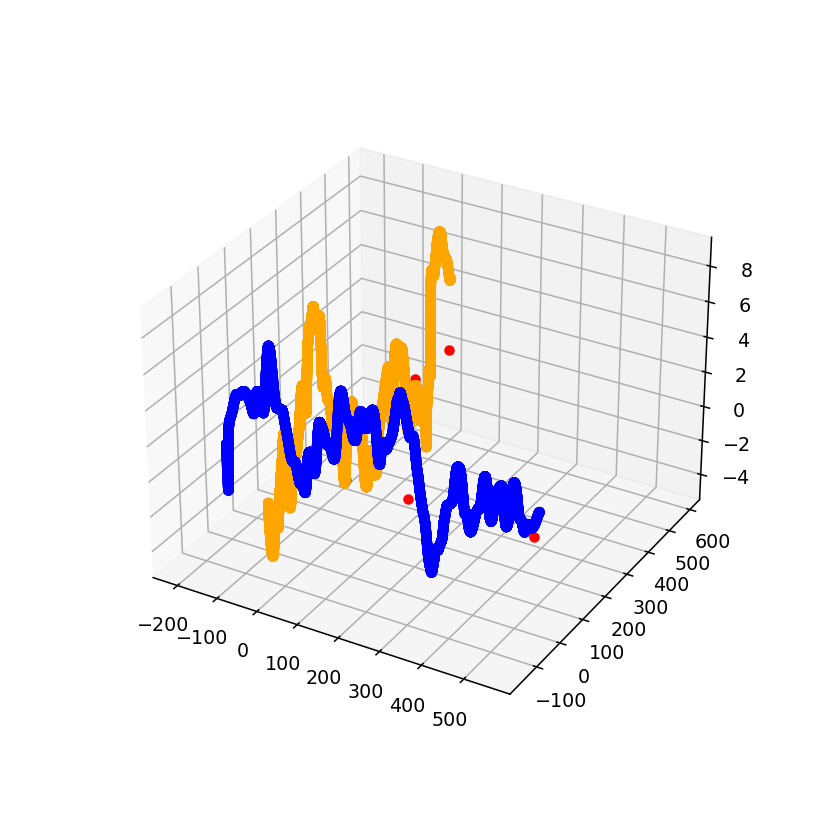

[-206.8610511    0.           0.       ]
[-56.8610511   0.          0.       ]
[93.1389489  0.         0.       ]
[243.1389489   0.          0.       ]
[393.1389489   0.          0.       ]
[543.1389489   0.          0.       ]
[-9.59820520e-15 -1.56750586e+02  0.00000000e+00]
[-4.13354207e-16 -6.75058649e+00  0.00000000e+00]
[8.77149679e-15 1.43249414e+02 0.00000000e+00]
[1.79563478e-14 2.93249414e+02 0.00000000e+00]
[2.71411988e-14 4.43249414e+02 0.00000000e+00]
[3.63260498e-14 5.93249414e+02 0.00000000e+00]


In [15]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

ax.scatter(extract_from_df(AC1_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC1_GT_Trajectory, 'gt_pos', 2), c='b')

ax.scatter(extract_from_df(AC2_GT_Trajectory, 'gt_pos', 0), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 1), 
           extract_from_df(AC2_GT_Trajectory, 'gt_pos', 2), c='orange')

# ax.scatter(AC1_Trk_Trajectory[:,2], 
#            AC1_Trk_Trajectory[:,3],
#            AC1_Trk_Trajectory[:,4], c='orange', alpha=0.5)

# ax.scatter(AC2_Trk_Trajectory[:,2], 
#            AC2_Trk_Trajectory[:,3],
#            AC2_Trk_Trajectory[:,4], c='orange', alpha=0.5)

for wpt in AC1_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

for wpt in AC2_WPTs:
    xx, yy, zz = wpt
    ax.scatter(xx, yy, zz, c='r')
    print(wpt)

    
# ax.set_xlim(-10, 510)
# ax.set_ylim(-100, 100)
# ax.set_zlim(-50,50)

plt.show()

In [16]:
AC1_State.time

74.30833333334792

In [17]:
AC2_State.time

73.75833333334842